In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

In [2]:
survey_df = pd.read_csv('../data/online-v1-prolific-sample.csv')
survey_df.head()

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Q_work_urban,Q_work_urban_3_TEXT,Q_demos_age,Q_demos_gender,Q_demos_income,Q_demos_race,Q_comments,PROLIFIC_PID,STUDY_ID,treatment
0,Start Date,End Date,Response Type,IP Address,Progress,Duration (in seconds),Finished,Recorded Date,Response ID,Recipient Last Name,...,Do you work in an urban area? - Selected Choice,Do you work in an urban area? - Not sure / Oth...,How old are you?,What is your gender?,What was your total household income before ta...,Choose one or more races that you consider you...,Any extra comments? (optional),PROLIFIC_PID,STUDY_ID,treatment
1,"{""ImportId"":""startDate"",""timeZone"":""America/De...","{""ImportId"":""endDate"",""timeZone"":""America/Denv...","{""ImportId"":""status""}","{""ImportId"":""ipAddress""}","{""ImportId"":""progress""}","{""ImportId"":""duration""}","{""ImportId"":""finished""}","{""ImportId"":""recordedDate"",""timeZone"":""America...","{""ImportId"":""_recordId""}","{""ImportId"":""recipientLastName""}",...,"{""ImportId"":""QID63""}","{""ImportId"":""QID63_3_TEXT""}","{""ImportId"":""QID30""}","{""ImportId"":""QID57""}","{""ImportId"":""QID25""}","{""ImportId"":""QID24""}","{""ImportId"":""QID58_TEXT""}","{""ImportId"":""PROLIFIC_PID""}","{""ImportId"":""STUDY_ID""}","{""ImportId"":""treatment""}"
2,2022-06-28 09:30:49,2022-06-28 09:32:52,0,*******,100,123,1,2022-06-28 09:32:52,R_125SdSXI0xLI29S,*******,...,1,NaN,4,1,6,1,NaN,5ae11f9709eae20001132c22,62bb1ba7f2c710e36fd2c1be,labeled
3,2022-06-28 09:30:31,2022-06-28 09:34:22,0,*******,100,231,1,2022-06-28 09:34:23,R_23V4Eyckqxl6Bmy,*******,...,2,NaN,7,1,5,1,I do not lean toward either party. I am a libe...,5dd311bde25acf3254f36c9c,62bb1ba7f2c710e36fd2c1be,unlabeled
4,2022-06-28 09:31:35,2022-06-28 09:35:34,0,*******,100,239,1,2022-06-28 09:35:35,R_2c5wLF9HxTeZ30h,*******,...,2,NaN,5,2,2,1,"None, but thank you!",5ba3e40d2d28760001a377bb,62bb1ba7f2c710e36fd2c1bf,labeled


In [3]:
print(list(survey_df.columns))

['StartDate', 'EndDate', 'Status', 'IPAddress', 'Progress', 'Duration (in seconds)', 'Finished', 'RecordedDate', 'ResponseId', 'RecipientLastName', 'RecipientFirstName', 'RecipientEmail', 'ExternalReference', 'LocationLatitude', 'LocationLongitude', 'DistributionChannel', 'UserLanguage', 'ProlificID ', 'Q_attn_1', 'Q_attn_2', 'Q_sandwich_1', 'Q_sandwich_2', 'Q_sandwich_3', 'Q_sandwich_4', 'Q_sandwich_5', 'Q_sandwich_1_labeled', 'Q_sandwich_2_labeled', 'Q_sandwich_3_labeled', 'Q_sandwich_4_labeled', 'Q_sandwich_5_labeled', 'Q_attn_check', 'Q_current_hunger', 'Q_priorities_1', 'Q_priorities_2', 'Q_priorities_3', 'Q_priorities_4', 'Q_priorities_5', 'Q_special_diet', 'Q_special_diet_6_TEXT', 'Q_past_vegetarian', 'Q_past_vegan', 'Q_vegetarian_not_me', 'Q_vegan_not_me', 'Q_good_for_env', 'Q_how_important_env', 'Q_attn_midway', 'Q_politics', 'Q_US_state', 'Q_live_urban', 'Q_work_urban', 'Q_work_urban_3_TEXT', 'Q_demos_age', 'Q_demos_gender', 'Q_demos_income', 'Q_demos_race', 'Q_comments', 'PR

## Data preprocessing


Transform into tables:


1. Respondent data table:

Contains all relevant non-choice data for a respondent

2. Menu choices table

```
ResponseId, labeled (1/0), QID, menu, comparison type (1-5), choice (1/0) 
```

In [4]:
choice_Q_prefix = 'Q_sandwich'
choice_Qs = [q for q in survey_df.columns if q.startswith(choice_Q_prefix)]
print(choice_Qs)

['Q_sandwich_1', 'Q_sandwich_2', 'Q_sandwich_3', 'Q_sandwich_4', 'Q_sandwich_5', 'Q_sandwich_1_labeled', 'Q_sandwich_2_labeled', 'Q_sandwich_3_labeled', 'Q_sandwich_4_labeled', 'Q_sandwich_5_labeled']


In [5]:
# extract the columns we use
respondent_columns = [
    'ResponseId', 
    'PROLIFIC_PID', # embedded variable set through URL params
    'Finished','Duration (in seconds)', 'RecordedDate',
    'Q_attn_1', 'Q_attn_2', 'Q_attn_check', 'Q_attn_midway', 
    'Q_current_hunger', 'Q_live_urban', 'Q_work_urban', 'Q_politics', 'Q_US_state',
    'Q_priorities_1', 'Q_priorities_2', 'Q_priorities_3', 'Q_priorities_4', 'Q_priorities_5',
    'Q_special_diet', 'Q_special_diet_6_TEXT', 
    'Q_past_vegetarian', 'Q_past_vegan', 
    'Q_vegetarian_not_me', 'Q_vegan_not_me', 
    'Q_good_for_env', 'Q_how_important_env',
    'Q_demos_age', 'Q_demos_gender', 'Q_demos_income', 'Q_demos_race', 
    'Q_comments',
    'treatment'
]

### Respondent table

In [6]:
respondent_df = survey_df.drop([0,1])[respondent_columns]
starting_respondent_N = respondent_df['ResponseId'].nunique()
print('N=%s total responses before data cleaning' % starting_respondent_N)
respondent_df.head(3)

N=568 total responses before data cleaning


,ResponseId,PROLIFIC_PID,Finished,Duration (in seconds),RecordedDate,Q_attn_1,Q_attn_2,Q_attn_check,Q_attn_midway,Q_current_hunger,...,Q_vegetarian_not_me,Q_vegan_not_me,Q_good_for_env,Q_how_important_env,Q_demos_age,Q_demos_gender,Q_demos_income,Q_demos_race,Q_comments,treatment
2,R_125SdSXI0xLI29S,5ae11f9709eae20001132c22,1,123,2022-06-28 09:32:52,21,5,"1,2",5,3,...,4,4,2,4,4,1,6,1,NaN,labeled
3,R_23V4Eyckqxl6Bmy,5dd311bde25acf3254f36c9c,1,231,2022-06-28 09:34:23,21,5,"1,2",5,2,...,3,3,2,4,7,1,5,1,I do not lean toward either party. I am a libe...,unlabeled
4,R_2c5wLF9HxTeZ30h,5ba3e40d2d28760001a377bb,1,239,2022-06-28 09:35:35,21,5,"1,2",5,2,...,4,4,1,5,5,2,2,1,"None, but thank you!",labeled


In [7]:
# only include completed surveys via Prolific
N_PROLIFIC_PID_na = len(respondent_df[respondent_df['PROLIFIC_PID'].isna()])
print('dropping %s non PROLIFIC responses' % N_PROLIFIC_PID_na)
respondent_df = respondent_df[respondent_df['PROLIFIC_PID'].notna()]
N_uncompleted = len(respondent_df[respondent_df['Finished'] != '1'])
respondent_df = respondent_df[respondent_df['Finished'] == '1']
print('dropping %s incomplete responses' % N_uncompleted)

dropping 1 non PROLIFIC responses
dropping 0 incomplete responses


In [8]:
def passed_attn_checks(row):
    if not ((row['Q_attn_1'] == 'twenty one') or (int(row['Q_attn_1']) == 21)):
        print(row['ResponseId'], 'failed Q_attn_1')
        return False
    if int(row['Q_attn_2']) != 5:
        print(row['ResponseId'], 'failed Q_attn_2')
        return False
    if row['Q_attn_check'] != '1,2':
        print(row['ResponseId'], 'failed Q_attn_check')
        return False
    if int(row['Q_attn_midway']) != 5:
        print(row['ResponseId'], 'failed Q_attn_midway')
        return False
    return True

In [9]:
respondent_df['passed_attn_checks'] = respondent_df.apply(passed_attn_checks, axis=1)
passed_attn_checks_ResponseId_list = list(respondent_df[respondent_df.passed_attn_checks == True].ResponseId)
print('%s/%s respondents passed all attention checks' % (len(passed_attn_checks_ResponseId_list), len(respondent_df)))
# passed_attn_checks_ResponseId_list

R_1Nagt8YYb9KXsgu failed Q_attn_check
R_25u12nxsbq17quY failed Q_attn_2
R_1ewLnYbEh64px5y failed Q_attn_2
R_3EbCFbWypJAH9eU failed Q_attn_2
R_31sGHSw29sejYZu failed Q_attn_check
R_XNtU8UZMHfqK8lX failed Q_attn_2
R_1Ov4PG2EqkoaNBI failed Q_attn_2
R_2sbRJWBoxeF0yHs failed Q_attn_2
R_3Hho2J2KAXLsDob failed Q_attn_2
R_3HUPi75tTdT9pnD failed Q_attn_2
R_1eLSotOLp5DjqJP failed Q_attn_2
R_1LLnNW2RfOKf93z failed Q_attn_midway
R_3fvnmHGH7Bmp938 failed Q_attn_2
R_33mAmfZaIBDBZiT failed Q_attn_2
R_3g8l72aZYNXtcZh failed Q_attn_check
R_1CjxgolIeuRdypP failed Q_attn_check
R_UDAbbOpDeLg8Jot failed Q_attn_check
R_1HqLpaBDw6P827V failed Q_attn_2
R_pR8DHCNXAHa8ZFv failed Q_attn_2
R_ahgvJfr1UphyDap failed Q_attn_check
R_1GVKbaKQiuw141N failed Q_attn_2
546/567 respondents passed all attention checks


Drop responses from participants who failed ANY attention check

In [10]:
print('dropping responses from participants who failed any attention check')
respondent_df = respondent_df[respondent_df['passed_attn_checks']]

dropping responses from participants who failed any attention check


### Codebook

In [11]:
# This is a dump from the recode values exported from qualtrics Q_US_state.
# Qualtrics put the states in alphabetical order for their recode value, did not code by FIPs
states_recode_text = '1\nAlabama\n2\nAlaska\n3\nArizona\n4\nArkansas\n5\nCalifornia\n6\nColorado\n7\nConnecticut\n8\nDelaware\n9\nDistrict of Columbia\n10\nFlorida\n11\nGeorgia\n12\nHawaii\n13\nIdaho\n14\nIllinois\n15\nIndiana\n16\nIowa\n17\nKansas\n18\nKentucky\n19\nLouisiana\n20\nMaine\n21\nMaryland\n22\nMassachusetts\n23\nMichigan\n24\nMinnesota\n25\nMississippi\n26\nMissouri\n27\nMontana\n28\nNebraska\n29\nNevada\n30\nNew Hampshire\n31\nNew Jersey\n32\nNew Mexico\n33\nNew York\n34\nNorth Carolina\n35\nNorth Dakota\n36\nOhio\n37\nOklahoma\n38\nOregon\n39\nPennsylvania\n40\nPuerto Rico\n41\nRhode Island\n42\nSouth Carolina\n43\nSouth Dakota\n44\nTennessee\n45\nTexas\n46\nUtah\n47\nVermont\n48\nVirginia\n49\nWashington\n50\nWest Virginia\n51\nWisconsin\n52\nWyoming\n53\nI do not reside in the United States'
states_recode_list = states_recode_text.split('\n')
states_choices_map = {states_recode_list[i]: states_recode_list[i+1] for i in range(0, len(states_recode_list), 2)}
# states_choices_map

In [12]:
# {QID: {Q: Q text, choices: map}}
codebook = {
    'Q_current_hunger': {
        'Q': 'How would you rank your current hunger level on a scale from 1 - 4?',
        'choices': {
            '1':'1 (Not hungry at all)','2':'2','3':'3','4':'4 (Very hungry)'
        },
    },
    'Q_special_diet':{
        'Q': 'Are you on any special diet? (select all that apply)',
        'choices': {
            '1':'Keto','2':'Pescatarian','3':'Vegetarian',
            '4':'Gluten free','5':'Vegan','6':'Other','7':'None'
        },
    },
    'Q_past_vegetarian': {
        'Q':'In the past 7 days, on how many days did you have a meal that contained any meat, poultry, or fish?',
        'choices': {
            '7': 7,
            '6': 6,
            '5': 5,
            '4': 4,
            '3': 3,
            '2': 2,
            '1': 1,
            '0': 0,
        },
    },
    'Q_past_vegan': {
        'Q':'In the past 7 days, on how many days did you eat a meal that contained any kind of animal product? (i.e. on how many days did you eat meat, poultry, fish, dairy, eggs, etc?)',
        'choices': {
            '7': 7,
            '6': 6,
            '5': 5,
            '4': 4,
            '3': 3,
            '2': 2,
            '1': 1,
            '0': 0,
        },
    },
    'Q_priorities': {
        'Q': 'How do you prioritize the following when choosing what to order for yourself off a menu?',
        'choices': {'1':'health','2':'cost','3':'taste','4':'filling','5':'usual_choice'},
    },
    'Q_good_for_env': {
        'Q':'How strongly do you agree with the following statement?\n"Vegetarian and vegan dishes are good for the environment."',
        'choices': {
            '1':'Strongly agree','2':'Agree','3':'Neutral',
            '4':'Disagree','5':'Strongly disagree'
        },
    },
    'Q_how_important_env': {
        'Q':'How important is environmental sustainability to you as an issue?',
        'choices': {
            '1':'Very much not important','2':'Not important',
            '3':'Neutral','4':'Somewhat important','5':'Very important'
        },
    },
    'Q_vegetarian_not_me': {
        'Q': 'How strongly do you agree with the following statement?\n"Vegetarian dishes are not for people like me."',
        'choices': {
            '1':'Strongly agree','2':'Agree','3':'Neutral',
            '4':'Disagree','5':'Strongly disagree'
        },
    },
    'Q_vegan_not_me': {
        'Q': 'How strongly do you agree with the following statement?\n"Vegan dishes are not for people like me."',
        'choices': {
            '1':'Strongly agree','2':'Agree','3':'Neutral',
            '4':'Disagree','5':'Strongly disagree'
        },
    },
    'Q_politics': {
        'Q':'Which of the following best describes your political preference?',
        'choices': {
            '1':'Strongly Democratic','2':'Democratic',
            '3':'Lean Democratic','4':'Lean Republican','5':'Republican','6':'Strongly Republican'
        }
    },
    'Q_live_urban': {
        'Q':'Which best describes the area you live?',
        'choices': {'1':'Urban','2':'Suburban','3':'Rural'},
    },
    'Q_work_urban': {
        'Q': 'Do you work in an urban area?',
        'choices': {'1':'Yes', '2':'No','3':'Not sure / Other'},
    },
    'Q_demos_gender': {
        'Q':'What is your gender?',
        'choices': {'1':'Male','2':'Female','3':'Other', '4':'Prefer not to answer'},
    },
    'Q_demos_age': {
        'Q': 'How old are you?',
        'choices': {
            '1':'Under 18', # should have none!
            '2':'18 - 24 years old',
            '3':'25 - 34 years old',
            '4':'35 - 44 years old',
            '5':'45 - 54 years old',
            '6':'55 - 64 years old',
            '7':'65+ years old'
        },
    },
    'Q_demos_income': {
        'Q': 'What was your total household income before taxes during the past 12 months?',
        'choices': {
            '1':'Less than \$25,000','2':'\$25,000 to \$49,999',
            '3':'\$50,000 to $74,999','4':'\$75,000 to \$99,999',
            '5':'\$100,000 to $149,999','6':'\$150,000 or more',
            '7':'Prefer not to say',
        },
    },
    'Q_demos_race': {
        'Q': 'Choose one or more races that you consider yourself to be',
        'choices': {
            '1':'White or Caucausian',
            '2':'Black or African American',
            '3':'American Indian/Native American or Alaska Native',
            '4':'Asian',
            '5':'Native Hawaiian or Other Pacific Islander',
            '6':'Other',
            '7':'Prefer not to say'
        },
    },
    'Q_US_state': {
        'Q':'In which state do you currently reside?',
        'choices': states_choices_map,
    },
}

In [13]:
for k in codebook.keys():
    if k == 'Q_priorities': continue
    assert(k in respondent_columns)

## Demographics


In which state do you currently reside?

Virginia            1
Indiana             1
Oregon              1
Alabama             1
South Carolina      1
Kansas              1
New Jersey          2
Michigan            2
Pennsylvania        3
New York            3
Texas               4
California          6
Vermont            21
New Hampshire      34
Rhode Island       39
Maine              55
Connecticut       110
Massachusetts     261
Name: Q_US_state, dtype: int64


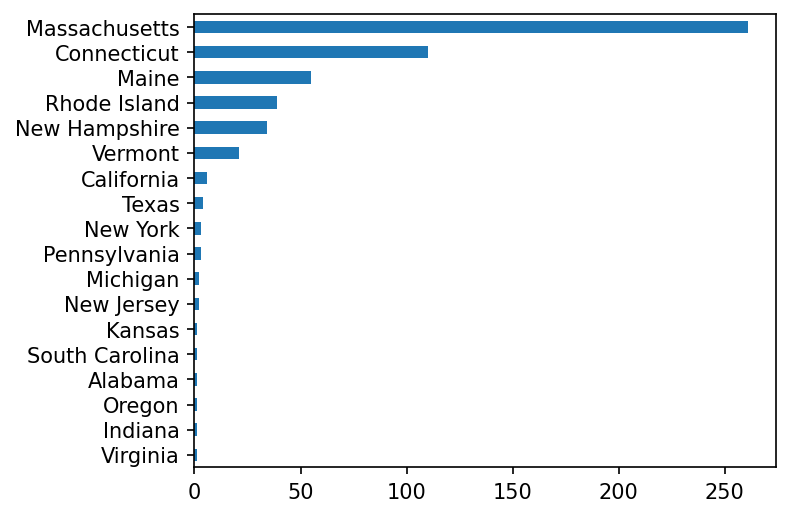

In [14]:
# Respondents by state
print('%s\n'%codebook['Q_US_state']['Q'])
fig,ax = plt.subplots(figsize=(5,4), dpi=150)
respondent_df['Q_US_state'].value_counts().sort_values().rename(
    codebook['Q_US_state']['choices']).plot.barh(ax=ax)
print(respondent_df['Q_US_state'].value_counts().sort_values().rename(
    codebook['Q_US_state']['choices']))

How old are you?


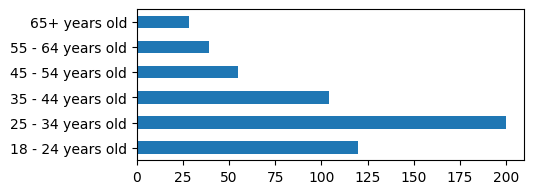

In [15]:
print('%s'%codebook['Q_demos_age']['Q'])
fig,ax = plt.subplots(figsize=(5,2), dpi=100)
_ = respondent_df['Q_demos_age'].value_counts().sort_index().rename(codebook['Q_demos_age']['choices']).plot.barh(ax=ax)
# print(respondent_df['Q_demos_age'].value_counts().sort_index().rename(codebook['Q_demos_age']['choices']))

What was your total household income before taxes during the past 12 months?



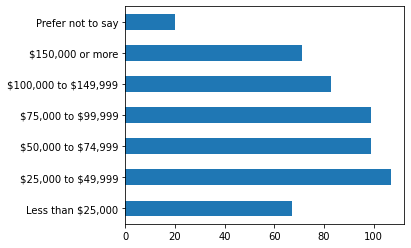

In [16]:
print('%s\n'%codebook['Q_demos_income']['Q'])
fig,ax = plt.subplots(figsize=(5,4))#, dpi=100)
_ = respondent_df['Q_demos_income'].value_counts().sort_index().rename(
    codebook['Q_demos_income']['choices']).plot.barh(ax=ax)
# print(respondent_df['Q_demos_income'].value_counts().sort_index().rename(codebook['Q_demos_income']['choices']))

                      count   (%)
gender                           
Female                  325  59.5
Male                    205  37.5
Other                    14   2.6
Prefer not to answer      2   0.4


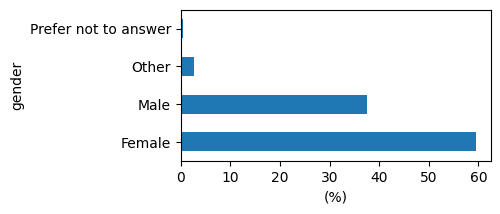

In [71]:
respondent_df['gender'] = respondent_df.Q_demos_gender.map(codebook['Q_demos_gender']['choices'])
fig,ax = plt.subplots(figsize=(4,2),dpi=100)
gender_counts = respondent_df.groupby(
    'gender'
)['ResponseId'].count().rename('count').to_frame()
gender_counts['(%)'] = 100*round(gender_counts['count']/gender_counts['count'].sum(), 3)
print(gender_counts)
gender_counts['(%)'].plot.barh(ax=ax)
_ = ax.set_xlabel('(%)')

1,2,4      1
1,4,5      1
1,5        1
5          1
3          1
2,4        1
1,6        3
1,3        4
6          5
7          6
1,2        6
1,4        7
2         24
4         37
1        448
Name: Q_demos_race, dtype: int64


Native Hawaiian or Other Pacific Islander             1
American Indian/Native American or Alaska Native      1
Black or African American                            24
Other                                                35
Asian                                                37
White or Caucausian                                 448
Name: race, dtype: int64

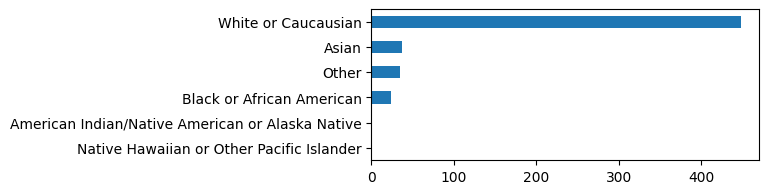

In [18]:
# Race: We put anyone who answered with 2 or more races or 'Prefer not to say' 
# in the 'Other' category
print(respondent_df['Q_demos_race'].value_counts().sort_values())
respondent_df['race'] = (respondent_df['Q_demos_race']
                       .apply(lambda r: r if r in ['1','2','3','4','5'] else '6')
                       .map(codebook['Q_demos_race']['choices']))
fig,ax = plt.subplots(1,1,figsize=(5,2),dpi=100)
respondent_df['race'].value_counts().sort_values().plot.barh()
respondent_df['race'].value_counts().sort_values()

Strongly Democratic    155
Democratic             158
Lean Democratic        140
Lean Republican         67
Republican              18
Strongly Republican      8
Name: Q_politics, dtype: int64


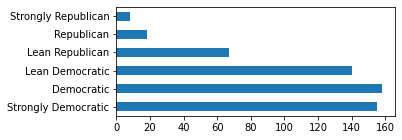

In [19]:
fig,ax = plt.subplots(figsize=(5,2))
respondent_df.Q_politics.value_counts().sort_index().rename(
    codebook['Q_politics']['choices']).plot.barh(ax=ax)
print(respondent_df.Q_politics.value_counts().sort_index().rename(
    codebook['Q_politics']['choices']))

Which best describes the area you live?


Suburban    332
Urban       127
Rural        87
Name: Q_live_urban, dtype: int64

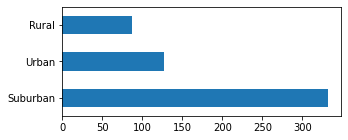

In [20]:
print(codebook['Q_live_urban']['Q'])
fig,ax = plt.subplots(figsize=(5,2))
respondent_df['Q_live_urban'].value_counts().rename(
    codebook['Q_live_urban']['choices']).plot.barh(ax=ax)
respondent_df['Q_live_urban'].value_counts().rename(
    codebook['Q_live_urban']['choices'])

Do you work in an urban area?


No                  340
Yes                 188
Not sure / Other     18
Name: Q_work_urban, dtype: int64

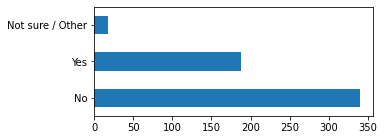

In [21]:
print(codebook['Q_work_urban']['Q'])
fig,ax = plt.subplots(figsize=(5,2))
respondent_df['Q_work_urban'].value_counts().rename(
    codebook['Q_work_urban']['choices']).plot.barh(ax=ax)
respondent_df['Q_work_urban'].value_counts().rename(
    codebook['Q_work_urban']['choices'])

Add a column indicating someone either lives or works in an urban area

In [22]:
def live_or_work_urban(row):
    return (row['Q_live_urban'] == '1') or (row['Q_work_urban'] == '1')

respondent_df['live_or_work_urban'] = respondent_df.apply(live_or_work_urban, axis=1)

Do you work in an urban area?


No                  340
Yes                 188
Not sure / Other     18
Name: Q_work_urban, dtype: int64

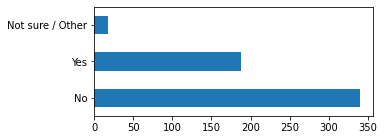

In [23]:
print(codebook['Q_work_urban']['Q'])
fig,ax = plt.subplots(figsize=(5,2))
respondent_df['Q_work_urban'].value_counts().rename(
    codebook['Q_work_urban']['choices']).plot.barh(ax=ax)
respondent_df['Q_work_urban'].value_counts().rename(
    codebook['Q_work_urban']['choices'])

Live or work urban

Live or work urban


False    325
True     221
Name: live_or_work_urban, dtype: int64

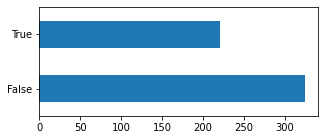

In [24]:
print('Live or work urban')
fig,ax = plt.subplots(figsize=(5,2))
respondent_df['live_or_work_urban'].value_counts().plot.barh(ax=ax)
respondent_df['live_or_work_urban'].value_counts()

More correlations between covariates

In [25]:
def styled_boxplot(df, by, column=None, ax=None):
    df.boxplot(
        column=column,
        by=by, ax=ax,
        grid=False,
        vert=False,
        showmeans=True,
        meanprops=dict(marker='D', markeredgecolor='black', markerfacecolor='firebrick'),
        boxprops=dict(linestyle='-', linewidth=1.5),
        flierprops=dict(linestyle='-', linewidth=1.5),
        medianprops=dict(linestyle='-', linewidth=2, color='firebrick'),
        whiskerprops=dict(linestyle='-', linewidth=1.5),
        #capprops=dict(linestyle='-', linewidth=1.5),
        showfliers=False,
        rot=0
    ).get_figure().suptitle('') # remove title automatically added by pandas

/Users/aberke/projects/ff/venv-ff/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator


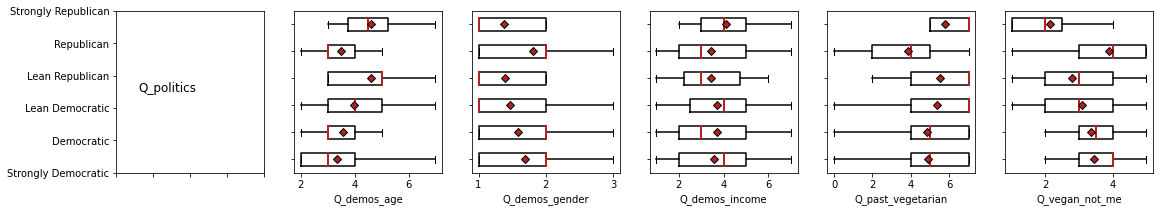

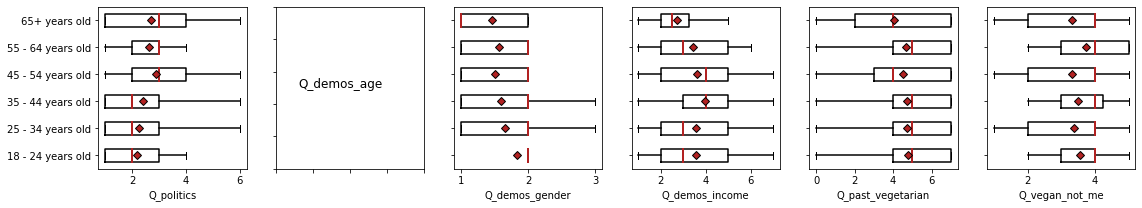

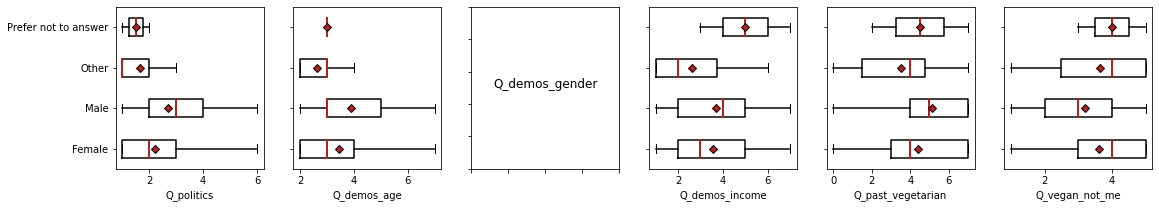

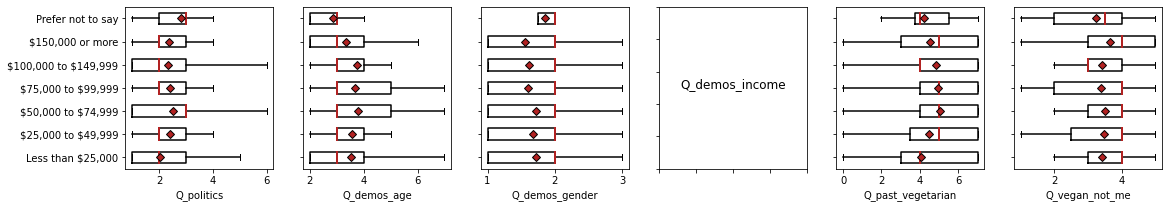

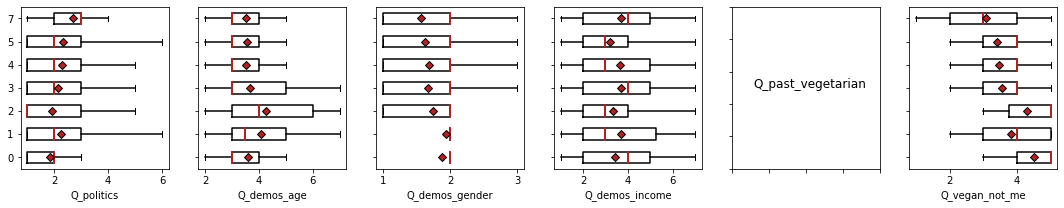

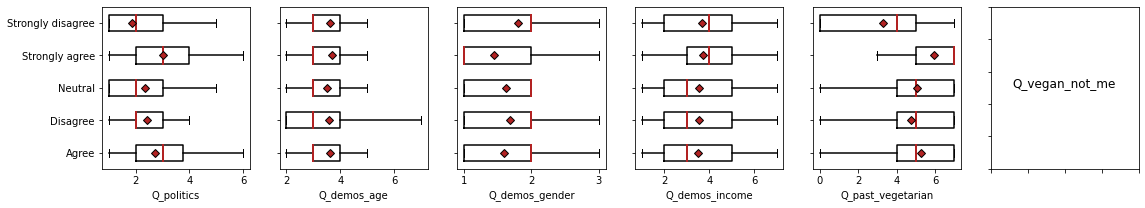

In [26]:
# Covariates correlations
cc_list = [
    'Q_politics', 
    'Q_demos_age', 
    'Q_demos_gender', 
    'Q_demos_income',
    'Q_past_vegetarian',
    'Q_vegan_not_me',
    
]
# make a df for analysis
df = respondent_df[cc_list].copy()


alt_map = ['Q_demos_income']
n_ccs = len(cc_list)


for i in range(n_ccs):
    fig, axes = plt.subplots(1,n_ccs, figsize=(3*n_ccs,3),
                             facecolor='w', edgecolor='k')
    for j in range(n_ccs):
        ax = axes[j]
        cc_i = cc_list[i]
        cc_j = cc_list[j]
        if i == j:
            if i == 0:
                ax.set_yticklabels(list(codebook[cc_i]['choices'].values()))
            else:
                ax.set_yticklabels([])
            ax.text(0.15, 0.5, cc_i, fontsize = 12)
            ax.set_xticklabels([])
            continue
        rdf = df[[cc_i, cc_j]].copy()
        if cc_i not in alt_map:
            rdf[cc_i] = rdf[cc_i].map(codebook[cc_i]['choices'])
        rdf[cc_j] = rdf[cc_j].astype(float)
        styled_boxplot(rdf, by=cc_i, column=cc_j, ax=ax)
        if j > 0:
            ax.set_yticklabels([])
        if (cc_i in alt_map) and (j==0):
            ax.set_yticklabels(codebook[cc_i]['choices'].values())
        ax.set_xlabel(cc_j)
        ax.set_title('')
        # ax.set_title('%s' % (cc_j))

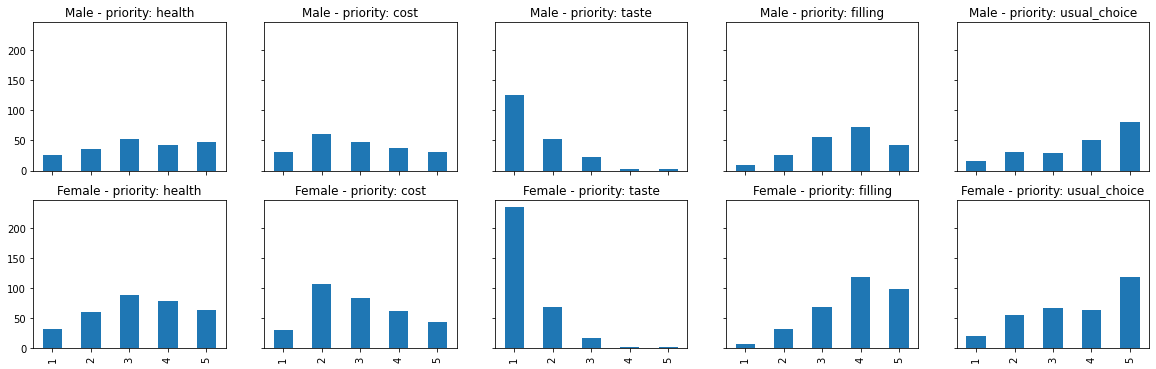

In [27]:
priorities_N = len(codebook['Q_priorities']['choices'])
fig, axes = plt.subplots(2, priorities_N, figsize=(4*priorities_N, 3*2), sharey=True, sharex=True)
for g, gender in enumerate(['Male','Female']):
    g_df = respondent_df[respondent_df['gender']==gender]
    for i, (p, priority) in enumerate(codebook['Q_priorities']['choices'].items()):
        Q_priority = 'Q_priorities_%s'%p
        ax = axes[g][i]
        ax.set_title('%s - priority: %s' % (gender, priority))
        g_df[Q_priority].value_counts().sort_index().plot.bar(ax=ax)
    


How would you rank your current hunger level on a scale from 1 - 4?
1    100
2    212
3    189
4     45
Name: Q_current_hunger, dtype: int64


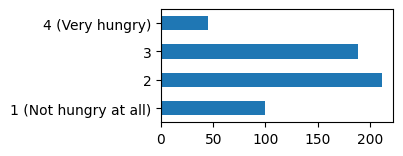

In [72]:
print(codebook['Q_current_hunger']['Q'])
fig,ax = plt.subplots(figsize=(3,1.5), dpi=100)
respondent_df['Q_current_hunger'].value_counts().sort_index().rename(codebook['Q_current_hunger']['choices']).plot.barh(ax=ax)
print(respondent_df['Q_current_hunger'].value_counts().sort_index())

None           447
Vegetarian      36
Other           21
Pescatarian     12
Keto             7
Gluten free      5
Vegan            5
Name: Q_special_diet, dtype: int64


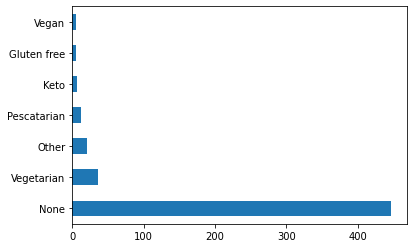

In [29]:
respondent_df.Q_special_diet.map(codebook['Q_special_diet']['choices']).value_counts().plot.barh()
print(respondent_df.Q_special_diet.map(codebook['Q_special_diet']['choices']).value_counts())

In [30]:
"""
Add in diet specific varaibles:
is_vegetarian
is_vegan
is_v : (is_vegetarian|is_vegan)
diet_other : said had a special diet that is not veg
diet_none : answered None for special diet
"""
respondent_df['is_vegetarian'] = respondent_df['Q_special_diet'].astype(str).apply(lambda d: 1 if ('3' in d) else 0)
respondent_df['is_vegan'] = respondent_df['Q_special_diet'].astype(str).apply(lambda d: 1 if ('5' in d) else 0)
respondent_df['is_v'] = respondent_df['Q_special_diet'].astype(str).apply(lambda d: 1 if (('3' in d) or ('5' in d)) else 0)
respondent_df['diet_other'] = respondent_df['Q_special_diet'].astype(str).apply(lambda d: ('3' not in d) and ('5' not in d) and ('7' not in d))
respondent_df['diet_none'] = respondent_df['Q_special_diet'].astype(str).apply(lambda d: '7' in d)
respondent_df['diet_none'].sum()

448

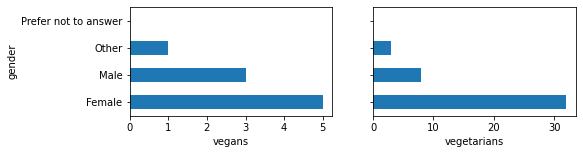

In [73]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8,2),sharey=True)
respondent_df.groupby('gender')['is_vegan'].sum().plot.barh(ax=ax1)
respondent_df.groupby('gender')['is_vegetarian'].sum().plot.barh(ax=ax2)
ax1.set_xlabel('vegans')
_ = ax2.set_xlabel('vegetarians')

How strongly do you agree with the following statement?
"Vegan dishes are not for people like me."



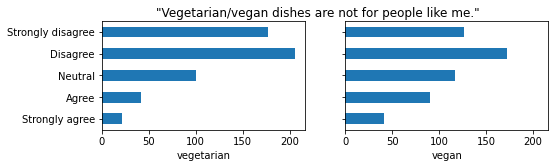

In [74]:
print('%s\n'%codebook['Q_vegan_not_me']['Q'])
fig,axes = plt.subplots(1,2,figsize=(8,2),sharey=True,sharex=True)
fig.suptitle('"Vegetarian/vegan dishes are not for people like me."')
respondent_df['Q_vegetarian_not_me'].value_counts().sort_index().rename(
    codebook['Q_vegetarian_not_me']['choices']).plot.barh(ax=axes[0])
axes[0].set_xlabel("vegetarian")
respondent_df['Q_vegan_not_me'].value_counts().sort_index().rename(
    codebook['Q_vegan_not_me']['choices']).plot.barh(ax=axes[1])
_ = axes[1].set_xlabel("vegan")

How important is environmental sustainability to you as an issue?
Very much not important     18
Not important               27
Neutral                     52
Somewhat important         234
Very important             215
Name: Q_how_important_env, dtype: int64


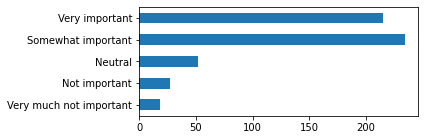

In [75]:
print(codebook['Q_how_important_env']['Q'])
fig,ax = plt.subplots(figsize=(5,2))
respondent_df['Q_how_important_env'].value_counts().sort_index().rename(codebook['Q_how_important_env']['choices']).plot.barh(ax=ax)
print(respondent_df['Q_how_important_env'].value_counts().sort_index().rename(codebook['Q_how_important_env']['choices']))

How strongly do you agree with the following statement?
"Vegetarian and vegan dishes are good for the environment."

Strongly agree       145
Agree                253
Neutral              134
Disagree               9
Strongly disagree      5
Name: Q_good_for_env, dtype: int64


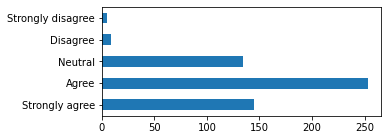

In [76]:
print('%s\n'%codebook['Q_good_for_env']['Q'])
fig,ax = plt.subplots(figsize=(5,2))
respondent_df['Q_good_for_env'].value_counts().sort_index().rename(codebook['Q_good_for_env']['choices']).plot.barh(ax=ax)
print(respondent_df['Q_good_for_env'].value_counts().sort_index().rename(codebook['Q_good_for_env']['choices']))

Code boolean (0/1) for whether people said env sustainability is important to them AND agree with the statement: "Vegetarian and vegan dishes are good for the environment."

In [77]:
print(codebook['Q_how_important_env'])
print(codebook['Q_good_for_env'])

{'Q': 'How important is environmental sustainability to you as an issue?', 'choices': {'1': 'Very much not important', '2': 'Not important', '3': 'Neutral', '4': 'Somewhat important', '5': 'Very important'}}
{'Q': 'How strongly do you agree with the following statement?\n"Vegetarian and vegan dishes are good for the environment."', 'choices': {'1': 'Strongly agree', '2': 'Agree', '3': 'Neutral', '4': 'Disagree', '5': 'Strongly disagree'}}


In [78]:
def get_v_important(row):
    if (row['Q_how_important_env'] in ['4','5']) and (row['Q_good_for_env'] in ['1','2']):
        return 1
    return 0
respondent_df['v_important'] = respondent_df.apply(get_v_important, axis=1)
# respondent_df[['v_important','Q_how_important_env','Q_good_for_env']].head()

### Menu choices table

```
ResponseId, labeled (0/1), QID, menu, choice_type (1-5), choice (1,2) 
```

In [79]:
# Wide data
choices_wide_df = (survey_df[['ResponseId'] + choice_Qs].drop([0,1]))
# drop data from respondents who failed attention checks
choices_wide_df = choices_wide_df[
    (choices_wide_df.ResponseId.isin(passed_attn_checks_ResponseId_list))
]
choices_wide_df.head(3)

,ResponseId,Q_sandwich_1,Q_sandwich_2,Q_sandwich_3,Q_sandwich_4,Q_sandwich_5,Q_sandwich_1_labeled,Q_sandwich_2_labeled,Q_sandwich_3_labeled,Q_sandwich_4_labeled,Q_sandwich_5_labeled
2,R_125SdSXI0xLI29S,NaN,NaN,NaN,NaN,NaN,0,0,1,1,1
3,R_23V4Eyckqxl6Bmy,0,0,0,1,0,NaN,NaN,NaN,NaN,NaN
4,R_2c5wLF9HxTeZ30h,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0


In [80]:
# Transform the wide data to long data.
choices_df = pd.melt(choices_wide_df, 
                     id_vars=['ResponseId'], value_vars=choice_Qs, 
                     var_name='QID', value_name='choice')
choices_df.head()

,ResponseId,QID,choice
0,R_125SdSXI0xLI29S,Q_sandwich_1,NaN
1,R_23V4Eyckqxl6Bmy,Q_sandwich_1,0
2,R_2c5wLF9HxTeZ30h,Q_sandwich_1,NaN
3,R_2B97XuOwuxSeQWA,Q_sandwich_1,0
4,R_2BrfiuSgy1SNVbL,Q_sandwich_1,NaN


In [81]:
# Add Q data
# ResponseId, labeled (0/1), QID, choice_type (1-5), choice (1/0)
# code choice, choice_type, labeled as numeric
choices_df['choice_type'] = choices_df['QID'].apply(lambda QID: int(QID.split('_')[2]))
choices_df['labeled'] = choices_df['QID'].apply(lambda QID: 1 if len(QID.split('_')) > 3 and QID.split('_')[3] == 'labeled' else 0)
# only keep responses for answered questions
print('dropping unanswered Qs; respondents answer %s = %s/%s of total Qs' % (
    len(choices_df.dropna())/len(choices_df), len(choices_df.dropna()), len(choices_df)
))
choices_df = choices_df.dropna()
choices_df['choice'] = choices_df['choice'].astype(int)
choices_df.head()

dropping unanswered Qs; respondents answer 0.5 = 2730/5460 of total Qs


,ResponseId,QID,choice,choice_type,labeled
1,R_23V4Eyckqxl6Bmy,Q_sandwich_1,0,1,0
3,R_2B97XuOwuxSeQWA,Q_sandwich_1,0,1,0
5,R_1DBZC4pjzVDsgT6,Q_sandwich_1,0,1,0
8,R_2SdGAfdbJx8Aq5C,Q_sandwich_1,0,1,0
11,R_2xL9vHDm0KfOgCa,Q_sandwich_1,0,1,0


## Modeling


## Main effects by comparison type

In [82]:
choices_type_names_dict = {
    1:'1=(labeled) vegetarian vs 0=meat',
    2:'1=(labeled) vegan vs 0=meat',
    3:'1=(labeled) vegetarian vs 0=vegetarian',
    4:'1=(labeled) vegan vs 0=vegan',
    5:'1=(labeled) vegan vs 0=vegetarian',
}

Add in demographic covariates to choices df

In [83]:
# code gender as male=1; otherwise=0
response_genders = respondent_df.set_index('ResponseId')['Q_demos_gender']
choices_df['male'] = choices_df['ResponseId'].apply(lambda r: 1 if response_genders[r]=='1' else 0)
# choices_df

In [84]:
choices_df['age'] = choices_df.ResponseId.map(
    respondent_df.set_index('ResponseId')['Q_demos_age'])
choices_df['income'] = choices_df.ResponseId.map(
    respondent_df.set_index('ResponseId')['Q_demos_income'])
choices_df['race'] = choices_df.ResponseId.map(
    respondent_df.set_index('ResponseId')['race'])

In [85]:
# Put in the diet related variables
for d in ['is_v', 'is_vegetarian', 'is_vegan']:
    choices_df[d] = choices_df.ResponseId.map(respondent_df.set_index('ResponseId')[d])

Test for for non-veg

In [86]:
def get_non_veg_choices_df(df):
    return df[(choices_df.is_v==0)]

By choice type, considering gender

In [87]:
# without interaction
non_veg_choices_df = get_non_veg_choices_df(choices_df)
for choice_type in non_veg_choices_df.choice_type.unique():
    print('\n-------- Model for comparison type %s ( %s ) --------\n' % (
        choice_type, choices_type_names_dict[choice_type]))
    c_df = non_veg_choices_df[non_veg_choices_df.choice_type == choice_type]
    choice_type_model = smf.logit("choice ~ labeled + male", data=c_df).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------

Optimization terminated successfully.
         Current function value: 0.606137
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  497
Model:                          Logit   Df Residuals:                      494
Method:                           MLE   Df Model:                            2
Date:                Mon, 04 Jul 2022   Pseudo R-squ.:                 0.02076
Time:                        23:10:01   Log-Likelihood:                -301.25
converged:                       True   LL-Null:                       -307.64
Covariance Type:            nonrobust   LLR p-value:                  0.001683
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4203  

In [46]:
# with interaction
non_veg_choices_df = get_non_veg_choices_df(choices_df)
for choice_type in non_veg_choices_df.choice_type.unique():
    print('\n-------- Model for comparison type %s ( %s ) --------\n' % (
        choice_type, choices_type_names_dict[choice_type]))
    c_df = non_veg_choices_df[non_veg_choices_df.choice_type == choice_type]
    choice_type_model = smf.logit("choice ~ labeled + male + labeled:male", data=c_df).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------

Optimization terminated successfully.
         Current function value: 0.605978
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  497
Model:                          Logit   Df Residuals:                      493
Method:                           MLE   Df Model:                            3
Date:                Mon, 04 Jul 2022   Pseudo R-squ.:                 0.02102
Time:                        22:51:11   Log-Likelihood:                -301.17
converged:                       True   LL-Null:                       -307.64
Covariance Type:            nonrobust   LLR p-value:                  0.004786
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.

With demographic covariates

In [47]:
# without interaction
non_veg_choices_df = get_non_veg_choices_df(choices_df)
for choice_type in non_veg_choices_df.choice_type.unique():
    print('\n-------- Model for comparison type %s ( %s ) --------\n' % (
        choice_type, choices_type_names_dict[choice_type]))
    c_df = non_veg_choices_df[non_veg_choices_df.choice_type == choice_type]
    choice_type_model = smf.logit("choice ~ labeled + male + age + income", data=c_df).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------

Optimization terminated successfully.
         Current function value: 0.594355
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  497
Model:                          Logit   Df Residuals:                      483
Method:                           MLE   Df Model:                           13
Date:                Mon, 04 Jul 2022   Pseudo R-squ.:                 0.03980
Time:                        22:51:11   Log-Likelihood:                -295.39
converged:                       True   LL-Null:                       -307.64
Covariance Type:            nonrobust   LLR p-value:                   0.02695
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.350

In [48]:
# with interaction
non_veg_choices_df = get_non_veg_choices_df(choices_df)
for choice_type in non_veg_choices_df.choice_type.unique():
    print('\n-------- Model for comparison type %s ( %s ) --------\n' % (
        choice_type, choices_type_names_dict[choice_type]))
    c_df = non_veg_choices_df[non_veg_choices_df.choice_type == choice_type]
    choice_type_model = smf.logit("choice ~ labeled + male + labeled:male + age + income", data=c_df).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------

Optimization terminated successfully.
         Current function value: 0.594218
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  497
Model:                          Logit   Df Residuals:                      482
Method:                           MLE   Df Model:                           14
Date:                Mon, 04 Jul 2022   Pseudo R-squ.:                 0.04002
Time:                        22:51:11   Log-Likelihood:                -295.33
converged:                       True   LL-Null:                       -307.64
Covariance Type:            nonrobust   LLR p-value:                   0.03850
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.

Alternative coding for gender:

gender = non-male/male: -0.5 / +0.5

so that “labeled” can be interpreted as an average effect when coding interaction

In [121]:
choices_df['gender'] = choices_df['male'].apply(lambda m: -0.5 if m == 0 else 0.5)

In [123]:
# with interaction
non_veg_choices_df = get_non_veg_choices_df(choices_df)
for choice_type in non_veg_choices_df.choice_type.unique():
    print('\n-------- Model for comparison type %s ( %s ) --------\ngender = non-male/male: -0.5 / +0.5\n' % (
        choice_type, choices_type_names_dict[choice_type]))
    c_df = non_veg_choices_df[non_veg_choices_df.choice_type == choice_type]
    choice_type_model = smf.logit("choice ~ labeled + gender + labeled:gender", data=c_df).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------
gender = non-male/male: -0.5 / +0.5

Optimization terminated successfully.
         Current function value: 0.605978
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  497
Model:                          Logit   Df Residuals:                      493
Method:                           MLE   Df Model:                            3
Date:                Mon, 04 Jul 2022   Pseudo R-squ.:                 0.02102
Time:                        23:33:55   Log-Likelihood:                -301.17
converged:                       True   LL-Null:                       -307.64
Covariance Type:            nonrobust   LLR p-value:                  0.004786
                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------

## Tests with moderator variables

Test moderation impact of whether participants state environmental sustainability is important to them and agree vegan/vegetarian meals are good for the environment.

Do vegan/vegetarian labels will still have a negative impact on participants who state environmental sustainability is important to them and agree vegan/vegetarian meals are good for the environment?

How does this compare to the impact of the past number of days someone did not eat meat?

What does this say about education campaigns?


In [88]:
choices_df['past_days_v'] = 7 - choices_df.ResponseId.map(
    respondent_df.set_index('ResponseId')['Q_past_vegetarian'].astype(int))

In [89]:
# v_important = 0/1; 
# 1 if participants stated environmental sustainability 
# is important to them and agree vegan/vegetarian meals are good for the environment
choices_df['v_important'] = choices_df.ResponseId.map(
    respondent_df.set_index('ResponseId')['v_important'])

In [92]:
non_veg_choices_df = get_non_veg_choices_df(choices_df)
for choice_type in non_veg_choices_df.choice_type.unique():
    print('\n-------- Model for comparison type %s ( %s ) --------\n' % (
        choice_type, choices_type_names_dict[choice_type]))
    c_df = non_veg_choices_df[non_veg_choices_df.choice_type == choice_type]
    choice_type_model = smf.logit("choice ~ labeled + v_important + labeled:v_important", data=c_df).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------

Optimization terminated successfully.
         Current function value: 0.604943
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  497
Model:                          Logit   Df Residuals:                      493
Method:                           MLE   Df Model:                            3
Date:                Mon, 04 Jul 2022   Pseudo R-squ.:                 0.02269
Time:                        23:14:35   Log-Likelihood:                -300.66
converged:                       True   LL-Null:                       -307.64
Covariance Type:            nonrobust   LLR p-value:                  0.002960
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Inter

In [93]:
non_veg_choices_df = get_non_veg_choices_df(choices_df)
for choice_type in non_veg_choices_df.choice_type.unique():
    print('\n-------- Model for comparison type %s ( %s ) --------\n' % (
        choice_type, choices_type_names_dict[choice_type]))
    c_df = non_veg_choices_df[non_veg_choices_df.choice_type == choice_type]
    choice_type_model = smf.logit("choice ~ labeled + past_days_v + labeled:past_days_v", data=c_df).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------

Optimization terminated successfully.
         Current function value: 0.592120
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  497
Model:                          Logit   Df Residuals:                      493
Method:                           MLE   Df Model:                            3
Date:                Mon, 04 Jul 2022   Pseudo R-squ.:                 0.04341
Time:                        23:14:36   Log-Likelihood:                -294.28
converged:                       True   LL-Null:                       -307.64
Covariance Type:            nonrobust   LLR p-value:                 6.784e-06
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Inter

Test people's agreement with the statement that 'vegan dishes are not for people like me' as a moderator variable.

In [95]:
choices_df['vegan_not_me'] = choices_df.ResponseId.map(
    respondent_df.set_index('ResponseId')['Q_vegan_not_me']).astype(int)

In [96]:
codebook['Q_vegan_not_me']['choices']

{'1': 'Strongly agree',
 '2': 'Agree',
 '3': 'Neutral',
 '4': 'Disagree',
 '5': 'Strongly disagree'}

In [97]:
# without interaction
non_veg_choices_df = get_non_veg_choices_df(choices_df)
for choice_type in non_veg_choices_df.choice_type.unique():
    print('\n-------- Model for comparison type %s ( %s ) --------\n' % (
        choice_type, choices_type_names_dict[choice_type]))
    c_df = non_veg_choices_df[non_veg_choices_df.choice_type == choice_type]
    choice_type_model = smf.logit("choice ~ labeled + male + vegan_not_me + labeled:vegan_not_me", data=c_df).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------

Optimization terminated successfully.
         Current function value: 0.595976
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  497
Model:                          Logit   Df Residuals:                      492
Method:                           MLE   Df Model:                            4
Date:                Mon, 04 Jul 2022   Pseudo R-squ.:                 0.03718
Time:                        23:15:34   Log-Likelihood:                -296.20
converged:                       True   LL-Null:                       -307.64
Covariance Type:            nonrobust   LLR p-value:                 0.0001342
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Int

Test with is_vegetarian and is_vegan as moderators

In [98]:
for choice_type in choices_df.choice_type.unique():
    print('\n-------- Model for comparison type %s ( %s ) --------\n' % (choice_type,choices_type_names_dict[choice_type]))
    c_df = choices_df[choices_df.choice_type == choice_type]
    choice_type_model = smf.logit("choice ~ male + is_vegetarian + labeled + labeled:is_vegetarian", data=c_df).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------

         Current function value: 0.573680
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  546
Model:                          Logit   Df Residuals:                      541
Method:                           MLE   Df Model:                            4
Date:                Mon, 04 Jul 2022   Pseudo R-squ.:                  0.1294
Time:                        23:17:14   Log-Likelihood:                -313.23
converged:                      False   LL-Null:                       -359.78
Covariance Type:            nonrobust   LLR p-value:                 2.890e-19
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.4167     

/Users/aberke/projects/ff/venv-ff/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Test with priority:health as a moderator, using whether health rated in top 2 priorities

Also: 
Test with priority:filling as a moderator, using whether health rated in top 2 priorities

In [99]:
Q_priorities_col_map = {'Q_priorities_%s'%k:'Q_priorities_%s'%v for k,v in codebook['Q_priorities']['choices'].items()}
# Q_priorities_col_map

In [100]:
# priority_health: whether health in top 1-2 priorities
choices_df['priority_health'] = choices_df['ResponseId'].map(respondent_df.set_index('ResponseId').rename(
    columns=Q_priorities_col_map
)['Q_priorities_health'].apply(lambda h: 1 if h in ['1','2'] else 0))

# priority_filling: whether filling in top 1-2 priorities
choices_df['priority_filling'] = choices_df['ResponseId'].map(respondent_df.set_index('ResponseId').rename(
    columns=Q_priorities_col_map
)['Q_priorities_filling'].apply(lambda p: 1 if p in ['1','2'] else 0))
# choices_df['priority_filling'].head(10)

In [101]:
# with priority health as a moderator
non_veg_choices_df = get_non_veg_choices_df(choices_df)
for choice_type in non_veg_choices_df.choice_type.unique():
    print('\n-------- Model for comparison type %s ( %s ) --------\n' % (
        choice_type, choices_type_names_dict[choice_type]))
    c_df = non_veg_choices_df[non_veg_choices_df.choice_type == choice_type]
    choice_type_model = smf.logit(
        "choice ~ labeled + male + priority_health + labeled:priority_health", 
        data=c_df
    ).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------

Optimization terminated successfully.
         Current function value: 0.599528
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  497
Model:                          Logit   Df Residuals:                      492
Method:                           MLE   Df Model:                            4
Date:                Mon, 04 Jul 2022   Pseudo R-squ.:                 0.03144
Time:                        23:17:14   Log-Likelihood:                -297.97
converged:                       True   LL-Null:                       -307.64
Covariance Type:            nonrobust   LLR p-value:                 0.0006730
                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

With priority filling and hunger level as moderators

In [102]:
print('%0.2f respondents prioritize filling' % (choices_df['priority_filling'].sum()/len(choices_df)))

0.14 respondents prioritize filling


For hunger, we code current hunger level 3, 4 as hungry.

In [103]:
choices_df['hungry'] = choices_df['ResponseId'].map(
    respondent_df.set_index('ResponseId')['Q_current_hunger'].apply(lambda h: 1 if h in ['3','4'] else 0)
)
print('%0.2f respondents are hungry' % (choices_df['hungry'].sum()/len(choices_df)))

choices_df['hungry_or_prioritize_filling'] = \
    choices_df.apply(lambda r: 1 if (r['hungry'] + r['priority_filling'] > 0) else 0, axis=1)

print('%0.2f respondents are hungry or priotize filling' % (choices_df['hungry_or_prioritize_filling'].sum()/len(choices_df)))

0.43 respondents are hungry
0.51 respondents are hungry or priotize filling


In [104]:
# with priority filling as a moderator
non_veg_choices_df = get_non_veg_choices_df(choices_df)
for choice_type in non_veg_choices_df.choice_type.unique():
    print('\n-------- Model for comparison type %s ( %s ) --------\n' % (
        choice_type, choices_type_names_dict[choice_type]))
    c_df = non_veg_choices_df[non_veg_choices_df.choice_type == choice_type]
    choice_type_model = smf.logit(
        "choice ~ labeled + male + hungry_or_prioritize_filling + labeled:hungry_or_prioritize_filling", 
        data=c_df
    ).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------

Optimization terminated successfully.
         Current function value: 0.605899
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  497
Model:                          Logit   Df Residuals:                      492
Method:                           MLE   Df Model:                            4
Date:                Mon, 04 Jul 2022   Pseudo R-squ.:                 0.02115
Time:                        23:17:16   Log-Likelihood:                -301.13
converged:                       True   LL-Null:                       -307.64
Covariance Type:            nonrobust   LLR p-value:                   0.01122
                                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

With political leaning as moderator (non-veg only)

Note responses are skewed towards democratic learning participants

In [105]:
choices_df['politics'] = \
    choices_df['ResponseId'].map(respondent_df.set_index('ResponseId')['Q_politics'].astype(float))
choices_df['politics'].describe()

count    2730.000000
mean        2.375458
std         1.192402
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         6.000000
Name: politics, dtype: float64

In [106]:
non_veg_choices_df = get_non_veg_choices_df(choices_df)
for choice_type in non_veg_choices_df.choice_type.unique():
    print('\n-------- Model for comparison type %s ( %s ) --------\n' % (choice_type,choices_type_names_dict[choice_type]))
    c_df = non_veg_choices_df[non_veg_choices_df.choice_type == choice_type]
    choice_type_model = smf.logit("choice ~ labeled + politics + labeled:politics", data=c_df).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------

Optimization terminated successfully.
         Current function value: 0.597654
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  497
Model:                          Logit   Df Residuals:                      492
Method:                           MLE   Df Model:                            4
Date:                Mon, 04 Jul 2022   Pseudo R-squ.:                 0.03447
Time:                        23:17:16   Log-Likelihood:                -297.03
converged:                       True   LL-Null:                       -307.64
Covariance Type:            nonrobust   LLR p-value:                 0.0002883
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept  

With urban as moderator (menu: sandwich; non-veg only)

In [107]:
choices_df['live_or_work_urban'] = choices_df['ResponseId'].map(
    respondent_df.set_index('ResponseId')['live_or_work_urban'].apply(lambda u: 1 if u else 0))
# choices_df['live_or_work_urban']

In [108]:
non_veg_choices_df = get_non_veg_choices_df(choices_df)
for choice_type in non_veg_choices_df.choice_type.unique():
    print('\n-------- Model for comparison type %s ( %s ) --------\n' % (choice_type,choices_type_names_dict[choice_type]))
    c_df = non_veg_choices_df[non_veg_choices_df.choice_type == choice_type]
    choice_type_model = smf.logit("choice ~ labeled + male + live_or_work_urban + labeled:live_or_work_urban", data=c_df).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------

Optimization terminated successfully.
         Current function value: 0.605741
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  497
Model:                          Logit   Df Residuals:                      492
Method:                           MLE   Df Model:                            4
Date:                Mon, 04 Jul 2022   Pseudo R-squ.:                 0.02140
Time:                        23:17:17   Log-Likelihood:                -301.05
converged:                       True   LL-Null:                       -307.64
Covariance Type:            nonrobust   LLR p-value:                   0.01049
                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------

### Multilevel modeling


We also use a hierarchical logistic regression model, where choices from all choice types are included in the model, and the participant-level effect is controlled for.

In [109]:
from pymer4.models import Lmer

In [110]:
non_veg_choices_df = get_non_veg_choices_df(choices_df)
m = Lmer("choice ~ labeled + male + (labeled|ResponseId)", data=non_veg_choices_df, family="binomial")
m.fit()

unable to evaluate scaled gradient 

Model failed to converge: degenerate  Hessian with 1 negative eigenvalues 

Formula: choice~labeled+male+(labeled|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 2485	 Groups: {'ResponseId': 497.0}

Log-likelihood: -1596.028 	 AIC: 3204.055

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.166  0.407
ResponseId      labeled  0.571  0.756

                    IV1      IV2  Corr
ResponseId  (Intercept)  labeled  -0.3

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.489,-0.640,-0.338,0.077,0.613,0.528,0.713,0.380,0.345,0.416,-6.358,0.000,***
labeled,-0.245,-0.452,-0.037,0.106,0.783,0.636,0.963,0.439,0.389,0.491,-2.313,0.021,*
male,-0.141,-0.344,0.062,0.103,0.868,0.709,1.064,0.465,0.415,0.515,-1.364,0.173,


In [111]:
non_veg_choices_df = get_non_veg_choices_df(choices_df)
m = Lmer("choice ~ labeled + male + labeled:male + (labeled|ResponseId)", data=non_veg_choices_df, family="binomial")
m.fit()

unable to evaluate scaled gradient 

Model failed to converge: degenerate  Hessian with 1 negative eigenvalues 

Formula: choice~labeled+male+labeled:male+(labeled|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 2485	 Groups: {'ResponseId': 497.0}

Log-likelihood: -1595.980 	 AIC: 3205.960

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.166  0.407
ResponseId      labeled  0.572  0.756

                    IV1      IV2   Corr
ResponseId  (Intercept)  labeled -0.304

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.479,-0.642,-0.316,0.083,0.619,0.526,0.729,0.382,0.345,0.422,-5.766,0.000,***
labeled,-0.270,-0.531,-0.009,0.133,0.764,0.588,0.991,0.433,0.370,0.498,-2.026,0.043,*
male,-0.167,-0.427,0.094,0.133,0.846,0.652,1.098,0.458,0.395,0.523,-1.255,0.210,
labeled:male,0.065,-0.349,0.480,0.212,1.068,0.705,1.616,0.516,0.414,0.618,0.309,0.757,


With demographic covariates

In [112]:
non_veg_choices_df = get_non_veg_choices_df(choices_df)
m = Lmer("choice ~ labeled + male + (labeled|ResponseId) + age + income", data=non_veg_choices_df, family="binomial")
m.fit()

unable to evaluate scaled gradient 

Model failed to converge: degenerate  Hessian with 1 negative eigenvalues 

Formula: choice~labeled+male+(labeled|ResponseId)+age+income

Family: binomial	 Inference: parametric

Number of observations: 2485	 Groups: {'ResponseId': 497.0}

Log-likelihood: -1589.189 	 AIC: 3212.378

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.173  0.416
ResponseId      labeled  0.531  0.729

                    IV1      IV2   Corr
ResponseId  (Intercept)  labeled -0.419

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.750,-1.097,-0.404,0.177,0.472,0.334,0.668,0.321,0.250,0.400,-4.241,0.000,***
labeled,-0.217,-0.423,-0.012,0.105,0.805,0.655,0.988,0.446,0.396,0.497,-2.072,0.038,*
male,-0.186,-0.392,0.021,0.105,0.831,0.676,1.021,0.454,0.403,0.505,-1.761,0.078,.
age3,0.024,-0.248,0.297,0.139,1.025,0.780,1.346,0.506,0.438,0.574,0.175,0.861,
age4,0.161,-0.150,0.471,0.158,1.174,0.861,1.602,0.540,0.463,0.616,1.014,0.311,
age5,0.312,-0.069,0.694,0.195,1.366,0.933,2.001,0.577,0.483,0.667,1.604,0.109,
age6,0.484,0.061,0.908,0.216,1.623,1.063,2.478,0.619,0.515,0.712,2.244,0.025,*
age7,0.453,-0.019,0.925,0.241,1.574,0.981,2.523,0.611,0.495,0.716,1.882,0.060,.
income2,0.149,-0.219,0.518,0.188,1.161,0.803,1.679,0.537,0.445,0.627,0.794,0.427,
income3,0.168,-0.207,0.542,0.191,1.183,0.813,1.720,0.542,0.448,0.632,0.878,0.380,


In [113]:
non_veg_choices_df = get_non_veg_choices_df(choices_df)
m = Lmer("choice ~ labeled + male + labeled:male + (labeled|ResponseId) + age + income", data=non_veg_choices_df, family="binomial")
m.fit()

unable to evaluate scaled gradient 

Model failed to converge: degenerate  Hessian with 1 negative eigenvalues 

Formula: choice~labeled+male+labeled:male+(labeled|ResponseId)+age+income

Family: binomial	 Inference: parametric

Number of observations: 2485	 Groups: {'ResponseId': 497.0}

Log-likelihood: -1589.110 	 AIC: 3214.220

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.175  0.418
ResponseId      labeled  0.539  0.734

                    IV1      IV2   Corr
ResponseId  (Intercept)  labeled -0.434

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.737,-1.090,-0.383,0.180,0.479,0.336,0.682,0.324,0.252,0.405,-4.084,0.000,***
labeled,-0.249,-0.507,0.009,0.132,0.780,0.602,1.009,0.438,0.376,0.502,-1.890,0.059,.
male,-0.221,-0.491,0.048,0.137,0.801,0.612,1.049,0.445,0.380,0.512,-1.612,0.107,
age3,0.026,-0.247,0.299,0.139,1.026,0.781,1.348,0.506,0.439,0.574,0.186,0.852,
age4,0.159,-0.152,0.470,0.159,1.172,0.859,1.600,0.540,0.462,0.615,1.002,0.316,
age5,0.317,-0.065,0.698,0.195,1.372,0.937,2.010,0.578,0.484,0.668,1.625,0.104,
age6,0.488,0.065,0.911,0.216,1.629,1.067,2.488,0.620,0.516,0.713,2.260,0.024,*
age7,0.458,-0.015,0.930,0.241,1.580,0.985,2.535,0.612,0.496,0.717,1.899,0.058,.
income2,0.145,-0.224,0.515,0.188,1.157,0.799,1.673,0.536,0.444,0.626,0.772,0.440,
income3,0.167,-0.207,0.542,0.191,1.182,0.813,1.719,0.542,0.448,0.632,0.874,0.382,


In [124]:
print('Alternative coding for gender: gender = non-male/male: -0.5 / +0.5')
non_veg_choices_df = get_non_veg_choices_df(choices_df)
m = Lmer("choice ~ labeled + gender + labeled:gender + (labeled|ResponseId)", data=non_veg_choices_df, family="binomial")
m.fit()

Alternative coding for gender: gender = non-male/male: -0.5 / +0.5
Formula: choice~labeled+gender+labeled:gender+(labeled|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 2485	 Groups: {'ResponseId': 497.0}

Log-likelihood: -1595.980 	 AIC: 3205.960

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.166  0.407
ResponseId      labeled  0.555  0.745

                    IV1      IV2   Corr
ResponseId  (Intercept)  labeled -0.281

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.562,-0.695,-0.430,0.068,0.570,0.499,0.651,0.363,0.333,0.394,-8.312,0.000,***
labeled,-0.237,-0.450,-0.024,0.109,0.789,0.638,0.976,0.441,0.389,0.494,-2.179,0.029,*
gender,-0.167,-0.427,0.094,0.133,0.846,0.652,1.098,0.458,0.395,0.523,-1.254,0.210,
labeled:gender,0.065,-0.349,0.480,0.212,1.068,0.705,1.616,0.516,0.414,0.618,0.309,0.757,


In [115]:
eq = "choice ~ labeled + (labeled|ResponseId) + priority_health + labeled:priority_health"
m = Lmer(eq, data=non_veg_choices_df, family="binomial")
m.fit()

[1] "Model is nearly unidentifiable: large eigenvalue ratio\n - Rescale variables?"
[2] " \n"                                                                          

Formula: choice~labeled+(labeled|ResponseId)+priority_health+labeled:priority_health

Family: binomial	 Inference: parametric

Number of observations: 2485	 Groups: {'ResponseId': 497.0}

Log-likelihood: -1589.103 	 AIC: 3192.206

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.164  0.405
ResponseId      labeled  0.554  0.744

                    IV1      IV2   Corr
ResponseId  (Intercept)  labeled -0.398

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.598,-0.748,-0.449,0.076,0.550,0.473,0.638,0.355,0.321,0.390,-7.863,0.000,***
labeled,-0.367,-0.608,-0.125,0.123,0.693,0.544,0.883,0.409,0.352,0.469,-2.970,0.003,**
priority_health,0.217,-0.073,0.507,0.148,1.243,0.930,1.661,0.554,0.482,0.624,1.469,0.142,
labeled:priority_health,0.419,-0.026,0.863,0.227,1.520,0.975,2.370,0.603,0.494,0.703,1.847,0.065,.


In [114]:
eq = "choice ~ labeled + (labeled|ResponseId) + past_days_v + labeled:past_days_v + v_important + labeled:v_important"
m = Lmer(eq, data=non_veg_choices_df, family="binomial")
m.fit()

unable to evaluate scaled gradient 

Model failed to converge: degenerate  Hessian with 1 negative eigenvalues 

Formula: choice~labeled+male+(labeled|ResponseId)+past_days_v+labeled:past_days_v+v_important+labeled:v_important

Family: binomial	 Inference: parametric

Number of observations: 2485	 Groups: {'ResponseId': 497.0}

Log-likelihood: -1582.223 	 AIC: 3184.445

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.108  0.329
ResponseId      labeled  0.579  0.761

                    IV1      IV2   Corr
ResponseId  (Intercept)  labeled -0.399

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.886,-1.133,-0.639,0.126,0.412,0.322,0.528,0.292,0.244,0.345,-7.038,0.000,***
labeled,-0.205,-0.575,0.165,0.189,0.815,0.563,1.180,0.449,0.360,0.541,-1.085,0.278,
male,-0.072,-0.273,0.129,0.103,0.930,0.761,1.138,0.482,0.432,0.532,-0.704,0.481,
past_days_v,0.103,0.033,0.173,0.036,1.109,1.034,1.189,0.526,0.508,0.543,2.893,0.004,**
v_important,0.290,0.022,0.557,0.136,1.336,1.023,1.745,0.572,0.506,0.636,2.124,0.034,*
labeled:past_days_v,0.036,-0.075,0.147,0.057,1.037,0.928,1.159,0.509,0.481,0.537,0.643,0.520,
labeled:v_important,-0.208,-0.628,0.212,0.214,0.812,0.533,1.236,0.448,0.348,0.553,-0.971,0.332,


## Plots

In [ ]:
TODO